In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
set_config(display='diagram')

warnings.filterwarnings('ignore')

color_pal = sns.color_palette()

PIVOTDATE = '01-01-2017'


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_parquet('../Data/Drought_Monitor_DSCI_Datasets/weekly_tift_drought_status_dsci.parquet')
df.head(5)

,prcp_accum,air_temp_observed,air_temp_max,air_temp_min,air_temp_avg,smp_2,smp_4,smp_20,smp_40,soil_temp_2,...,date_offset,week,season,D0,D1,D2,D3,D4,DSCI,drought_status
date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,4.650000,14.750000,22.750000,9.900000,15.750000,2.000000,5.700000,17.250000,25.050000,12.950000,...,1082,52,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-09,4.914286,10.542857,19.400000,6.414286,13.042857,1.942857,6.328571,16.800000,24.914286,10.928571,...,1089,1,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-16,5.600000,8.814286,20.257143,4.785714,12.428571,2.528571,7.614286,17.685714,25.114286,10.328571,...,1096,2,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-23,5.800000,9.433333,16.750000,5.800000,11.083333,1.283333,5.900000,17.233333,25.016667,10.583333,...,1103,3,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-30,7.285714,4.385714,9.442857,0.442857,4.671429,3.714286,8.300000,18.700000,25.700000,5.671429,...,1110,4,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought


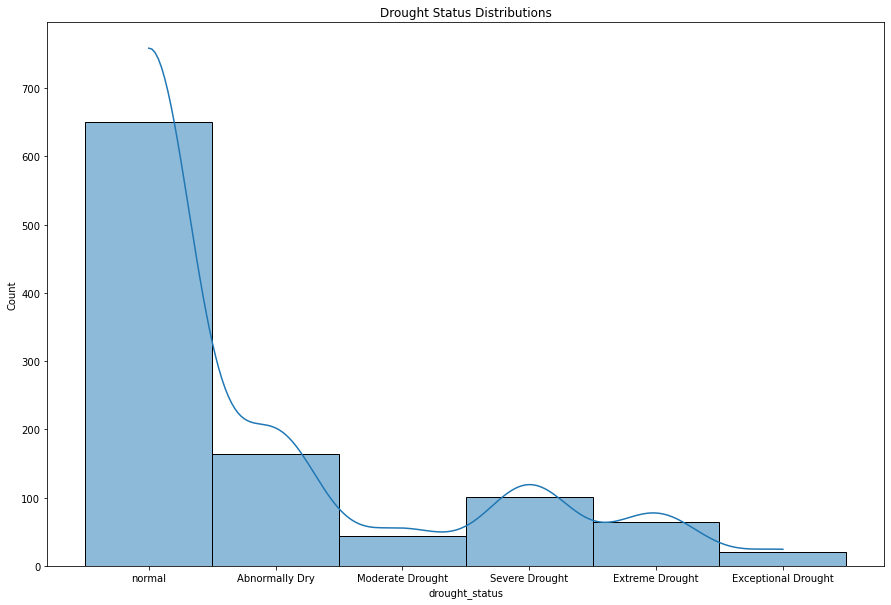

In [3]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(df, x='drought_status', kde=True)
ax.set_title('Drought Status Distributions')
plt.show()

In [4]:
le_ds = LabelEncoder() # basically this step converts the words to numberic values and keeps track of them. SO in other words there are 6 severities of drought so there are 6 encoded label classes
df['drought_status'] = le_ds.fit_transform(df['drought_status']) # we are now encoding drought status to be a numeric value
le_ds.classes_

array(['Abnormally Dry', 'Exceptional Drought', 'Extreme Drought',
       'Moderate Drought', 'Severe Drought', 'normal'], dtype=object)

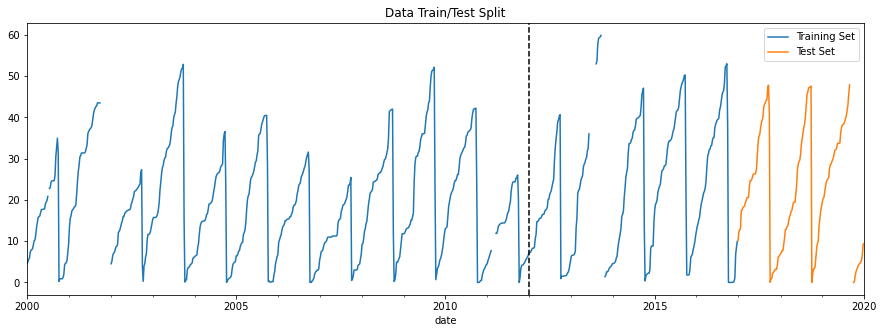

In [5]:
train = df.loc[df.index < PIVOTDATE] # this is where we can change the date of our training data. We do it this way because its a time series
test = df.loc[df.index >= PIVOTDATE]
fig, ax = plt.subplots(figsize=(15, 5))
train.prcp_accum.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.prcp_accum.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2012', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [6]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, gap=0) # this is a time series cross validator. Can also set max_train_size, and test_size. Might want to remove the time series gap
df = df.sort_index()

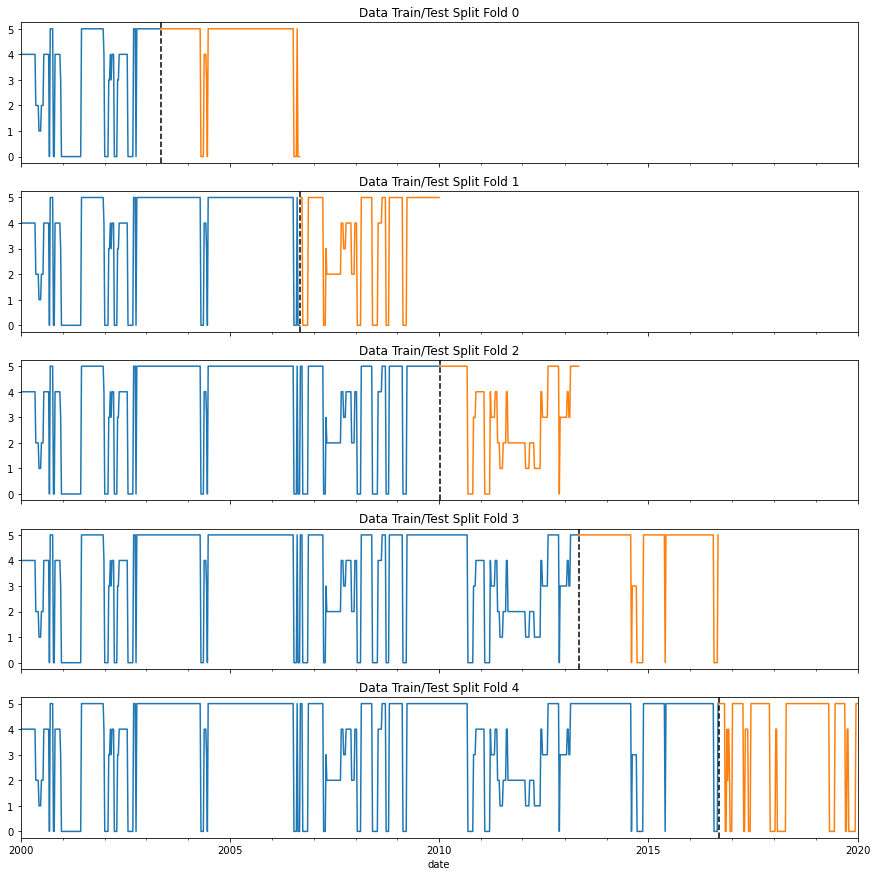

In [7]:
# is this step only for visual affect
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['drought_status'].plot(ax=axs[fold],
                      label='Training Set',
                      title=f'Data Train/Test Split Fold {fold}')
    test['drought_status'].plot(ax=axs[fold],
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show() # what are you even doing here. I do no think that anything happened here. This is just a visualization of 5 fold

In [8]:
def add_lags(df):
    target_map = df['drought_status'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # I do not really understand how the lags work. Will need some explanation
    return df

In [9]:
df = add_lags(df)

In [10]:
df['prcp'] = np.abs(df['prcp_accum'].diff()) # seems to getting the precipitation per day or week. Whatever the index is 

In [11]:
df = df.drop(['weekday'],axis=1)

In [12]:

le = LabelEncoder()

df['season'] = le.fit_transform(df['season'])
train = df.loc[df.index < PIVOTDATE] # set training dataframe up here
test = df.loc[df.index >= PIVOTDATE] # set testing dataframe here
df = df.drop(['date'], axis=1)
# df.head(5)
df['drought_status']

date
2000-01-02    4
2000-01-09    4
2000-01-16    4
2000-01-23    4
2000-01-30    4
             ..
2019-12-08    0
2019-12-15    0
2019-12-22    5
2019-12-29    5
2020-01-05    5
Name: drought_status, Length: 1045, dtype: int32

In [13]:
FEATURES = ['prcp_accum', 'air_temp_observed', 'air_temp_max', 'air_temp_min',
       'air_temp_avg', 'smp_2', 'smp_4', 'smp_20', 'smp_40', 'soil_temp_2',
       'soil_temp_4', 'soil_temp_8', 'soil_temp_20', 'soil_temp_40', 'wind_dir_avg',
       'wind_speed_avg', 'soil_temp_avg', 'smp_avg',
       'quarter', 'month', 'year',
       'weekofyear', 'date_offset', 'week', 'season', 'lag1', 'lag2', 'lag3', 'prcp']
TARGET = 'drought_status' #DSCI

In [14]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
print(y_train.isna().sum().sum())
print(y_test.isna().sum().sum())
# this should be zero because we should not need to impute anything in the following steps

0
0


In [16]:
len(FEATURES)

29

In [17]:
numeric_features = FEATURES[:]
numeric_features # this is great for visualization but I do not understand why this needs to be here. Seems like an extra step

['prcp_accum',
 'air_temp_observed',
 'air_temp_max',
 'air_temp_min',
 'air_temp_avg',
 'smp_2',
 'smp_4',
 'smp_20',
 'smp_40',
 'soil_temp_2',
 'soil_temp_4',
 'soil_temp_8',
 'soil_temp_20',
 'soil_temp_40',
 'wind_dir_avg',
 'wind_speed_avg',
 'soil_temp_avg',
 'smp_avg',
 'quarter',
 'month',
 'year',
 'weekofyear',
 'date_offset',
 'week',
 'season',
 'lag1',
 'lag2',
 'lag3',
 'prcp']

In [18]:
# Do this instead of step below
imputify = SimpleImputer(strategy='median')
scalify = StandardScaler() # For the time being Im not going to scalify

def preprocessData(data):
    imputedData = pd.DataFrame(imputify.fit_transform(data))
    imputedData.columns = data.columns
    imputedData.index = data.index
    processedData = imputedData
    return processedData

X_train_prepared = preprocessData(X_train)
X_test_prepared = preprocessData(X_test)
X_train_prepared.dtypes
# Need to figure out a simple way to check that there are no nans in a two dimensional numpy array

prcp_accum           float64
air_temp_observed    float64
air_temp_max         float64
air_temp_min         float64
air_temp_avg         float64
smp_2                float64
smp_4                float64
smp_20               float64
smp_40               float64
soil_temp_2          float64
soil_temp_4          float64
soil_temp_8          float64
soil_temp_20         float64
soil_temp_40         float64
wind_dir_avg         float64
wind_speed_avg       float64
soil_temp_avg        float64
smp_avg              float64
quarter              float64
month                float64
year                 float64
weekofyear           float64
date_offset          float64
week                 float64
season               float64
lag1                 float64
lag2                 float64
lag3                 float64
prcp                 float64
dtype: object

###Training and Testing

In [19]:
from hyperopt import hp
import numpy as np

space = {'max_depth': hp.choice("max_depth", [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,100]),
                   'gamma': hp.uniform('gamma', 0.9, 1),
                   'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
                   'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                   'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                   'n_estimators': hp.choice('n_estimators', [80,100,200,300,400,500]),
                   'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
                   'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]),
                #    'num_leaves': hp.quniform('num_leaves', 5, 50, 1),
                #    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
                   'seed': 42,
}

In [20]:
from hyperopt import tpe # tree parzen estimator
from hyperopt import Trials


trials = Trials() # Tracks trial results

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

def objective(space):
    clf=xgb.XGBClassifier(**space) # **space #XGBRegressor
    evaluation = [(X_train_prepared, y_train), (X_test_prepared, y_test)]
    
    clf.fit(X_train_prepared, y_train, eval_set=evaluation, eval_metric='merror', early_stopping_rounds=10, verbose = False) #eval metric rmse #mlogloss
    
    pred = clf.predict(X_test_prepared)

    # cv_accur = cross_val_score()
    # score = r2_score(y_test, pred)
    score = accuracy_score(y_test, pred)
    print("Score: ", score)

    return {'loss' : 1 - score, 'status' : STATUS_OK}

In [22]:
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals= 1000,
                        trials = trials)

Score:                                                  
0.689873417721519                                       
Score:                                                                           
0.26582278481012656                                                              
Score:                                                                           
0.6835443037974683                                                               
Score:                                                                           
0.689873417721519                                                                
Score:                                                                           
0.689873417721519                                                                
Score:                                                                           
0.6835443037974683                                                               
Score:                                                            

In [23]:
from hyperopt import space_eval

best_params = space_eval(space, best_hyperparams)
print(best_params)

{'colsample_bytree': 0.5004136937095744, 'gamma': 0.9792384372617052, 'learning_rate': 0.2, 'max_depth': 11, 'min_child_weight': 9.0, 'n_estimators': 200, 'reg_alpha': 180.0, 'reg_lambda': 0.10531369401421442, 'seed': 42, 'subsample': 1.0}


In [24]:
# Need to find a more efficient way to get the prediction froms the hyperparameter tuning so I do not have to do this step
# Just want to be able to look at the confusion matrix
clf=xgb.XGBClassifier(**best_params)
evaluation = [(X_train_prepared, y_train), (X_test_prepared, y_test)]
    
clf.fit(X_train_prepared, y_train, eval_set=evaluation, eval_metric='merror', early_stopping_rounds=10, verbose = False) #eval metric rmse #mlogloss
    
pred = clf.predict(X_test_prepared)
score = accuracy_score(y_test, pred)
print("Best Score: ", score)

print(pred)
print(pd.Series(y_test).array)


Best Score:  0.6962025316455697
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5]
<PandasArray>
[0, 5, 5, 5, 5, 5, 5, 5, 5, 5,
 ...
 0, 0, 0, 0, 0, 0, 0, 5, 5, 5]
Length: 158, dtype: int32


In [25]:
df_y_test = y_test.to_frame()
df_pred = pd.DataFrame(pred, columns=df_y_test.columns, index=df_y_test.index) # Ensure they have the same index

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (6).

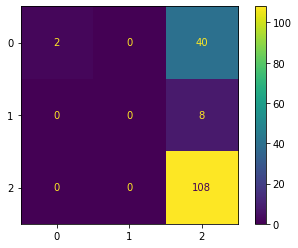

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_y_test, df_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= le_ds.classes_)
disp.plot() # Prints confusion matrix for only SVC

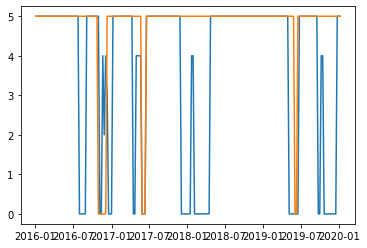

In [ ]:
plt.plot(df_y_test, label = 'original')
plt.plot(df_pred, label = 'prediction')